In [1]:
import json
with open('results.json', 'r') as fp:
    res = json.load(fp)

data = []
for entry in res:
    data += entry['data']['users']

addresses = [entry['id'] for entry in data]
print(len(addresses))

50946


In [2]:
from utils.gho_filter import filter_gho_users
gho_users = set(filter_gho_users(data))
len(gho_users)

2297

We have 51k users (including GHO users), the Debank API is slow, expensive and rate limited so processing everything would take a few hours.
Instead we can get a 1% margin of error at 99% confidence with a 10k subsample, so let's just use a subsample.

In [8]:
import random
non_gho_users = [a for a in addresses if a not in gho_users]
non_gho_sample = random.sample(non_gho_users, 10_000)
len(non_gho_sample)

10000

In [9]:
addresses = non_gho_sample + list(gho_users)

In [13]:
import asyncio
import aiohttp
import time
import nest_asyncio
import pickle
from tqdm import tqdm
from dotenv import load_dotenv
import os

nest_asyncio.apply()


load_dotenv()

DEBANK_API_KEY = os.getenv('DEBANK_API_KEY')

async def get_total_balance_async(address, session, timeout=30):
    url = f'https://pro-openapi.debank.com/v1/user/total_balance?id={address}'
    headers = {'accept': 'application/json', 'AccessKey': DEBANK_API_KEY}
    
    try:
        async with session.get(url, headers=headers, timeout=timeout) as response:
            if response.status == 200:
                result = await response.json()
                return address, result
            else:
                print(f"Error processing address {address}: HTTP {response.status}")
                return address, None
    except asyncio.TimeoutError:
        print(f"Timeout processing address {address}")
        return address, None
    except Exception as e:
        print(f"Error processing address {address}: {str(e)}")
        return address, None

async def process_addresses(addresses, batch_size=30, rate_limit=30, timeout=30):
    results = []
    pbar = tqdm(total=len(addresses), desc="Processing addresses")
    
    async with aiohttp.ClientSession() as session:
        for i in range(0, len(addresses), batch_size):
            batch = addresses[i:i+batch_size]
            start_time = time.time()
            
            tasks = [get_total_balance_async(address, session, timeout) for address in batch]
            batch_results = await asyncio.gather(*tasks)
            
            results.extend(batch_results)
            
            pbar.update(len(batch))
            
            with open('debank_balance_intermediate.pickle', 'wb') as fp:
                pickle.dump(results, fp)
            
            elapsed_time = time.time() - start_time
            if elapsed_time < 1:
                await asyncio.sleep(1 - elapsed_time)
    
    pbar.close()
    return results

try:
    with open('debank_balance_intermediate.pickle', 'rb') as fp:
        previous_results = pickle.load(fp)
    processed_addresses = set(result[0] for result in previous_results)
    remaining_addresses = [addr for addr in addresses if addr not in processed_addresses]
    print(f"Resuming from {len(previous_results)} previously processed addresses")
except FileNotFoundError:
    previous_results = []
    remaining_addresses = addresses
    
new_results = asyncio.get_event_loop().run_until_complete(process_addresses(remaining_addresses))

all_results = previous_results + new_results
with open('debank_balance_final.pickle', 'wb') as fp:
    pickle.dump(all_results, fp)

print("Processing completed. Results saved in 'debank_balance_final.pickle'")


Processing addresses:  78%|█████████████████████████████████████████            | 9540/12297 [12:21<07:54,  5.81it/s]

Error processing address 0x7f3e4d32918194647a5663c7160c8cbc17c789fb: HTTP 500



Processing addresses: 100%|████████████████████████████████████████████████████| 12297/12297 [18:12<00:00, 11.26it/s]


Processing completed. Results saved in 'debank_balance_final.pickle'


# Net Worth

In [15]:
worth = []
for entry in all_results:
    if entry[1] is None:
        continue
    worth.append({'address': entry[0], 'worth': entry[1]['total_usd_value']})

In [17]:
import pandas as pd
df_worth = pd.DataFrame(worth)

In [25]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use('ggplot')

/home/ben/.pyenv/versions/3.10.13/envs/boaenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6895: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


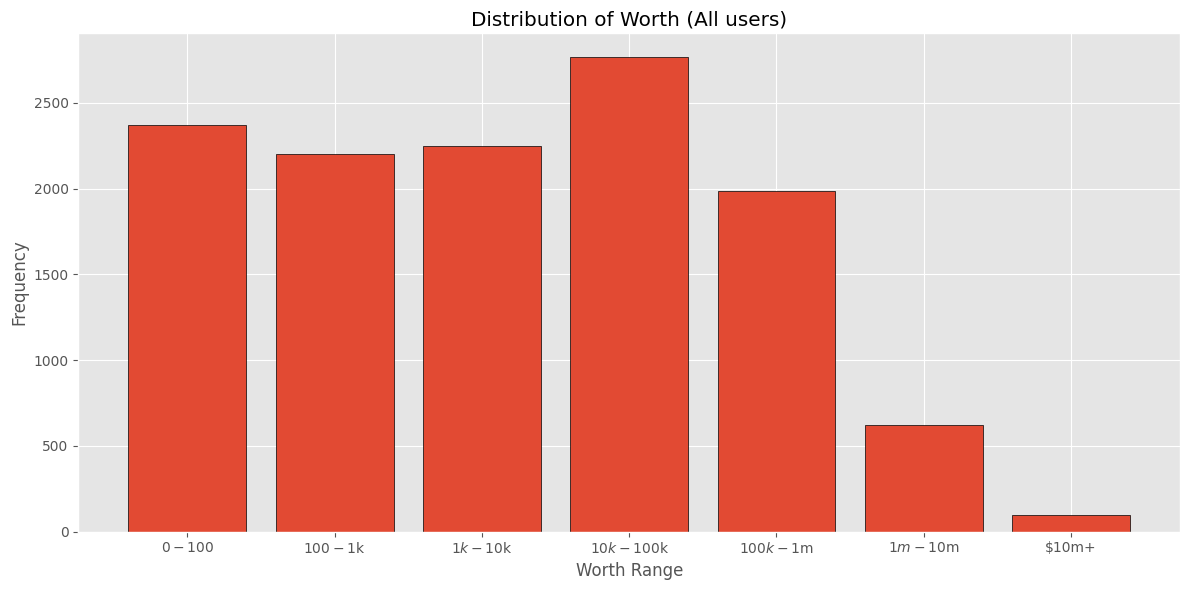

In [52]:
import matplotlib.pyplot as plt
import numpy as np

bins = [0, 100, 1000, 10000, 100000, 1000000, 10000000, np.inf]

labels = ['$0-$100', '$100-$1k', '$1k-$10k', '$10k-$100k', '$100k-$1m', '$1m-$10m', '$10m+']


plt.figure(figsize=(12, 6))
counts, edges, _ = plt.hist(df_worth['worth'], bins=bins, edgecolor='black')

plt.clf()
plt.bar(range(len(counts)), counts, edgecolor='black')


plt.xticks(range(len(labels)), labels)


plt.xlabel('Worth Range')
plt.ylabel('Frequency')
plt.title('Distribution of Worth (All users)')

plt.tight_layout()
plt.show()

In [53]:
gho_dis = dict(zip(labels, counts))
gho_dis

{'$0-$100': 2370.0,
 '$100-$1k': 2204.0,
 '$1k-$10k': 2251.0,
 '$10k-$100k': 2767.0,
 '$100k-$1m': 1984.0,
 '$1m-$10m': 622.0,
 '$10m+': 98.0}

In [54]:
{k: v / sum(gho_dis.values()) * 100 for k,v in gho_dis.items()}

{'$0-$100': 19.274560832791153,
 '$100-$1k': 17.92452830188679,
 '$1k-$10k': 18.3067664281067,
 '$10k-$100k': 22.503253090435916,
 '$100k-$1m': 16.135328562134028,
 '$1m-$10m': 5.058555627846454,
 '$10m+': 0.797007156798959}

In [31]:
df_worth[df_worth['address'].isin(gho_users)]

,address,worth
9999,0xe607091f472bb6ab38606a3192d76b8da4a30d77,2.426299e+02
10000,0x4aa21400c1d085cf60a7002499d75cbb3a69b1ab,5.272788e+04
10001,0xa76d3d369b3cdcd6582d67e2ce81768e865b48c1,9.625492e+02
10002,0x941dc2bf371c6e4b56d4b5e14246a09208335ce5,1.378252e+06
10003,0xcf67e96da5e45892d371dc22da7b71003a34a815,5.300682e+03
...,...,...
12291,0xe3f0e88cfebfdb66d8591d9dbdcd14c6ebab485b,2.186855e+03
12292,0x1c446ba9fea8b6fa251ec5d4e271922c47b1e21c,1.879796e+05
12293,0x8cc8aa103bfe1cd8755dc80c64539370b587909f,2.377477e+04
12294,0xf212ce21a97dbe30999a4c2b309d278bccbb686a,1.082150e+05


/home/ben/.pyenv/versions/3.10.13/envs/boaenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6895: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


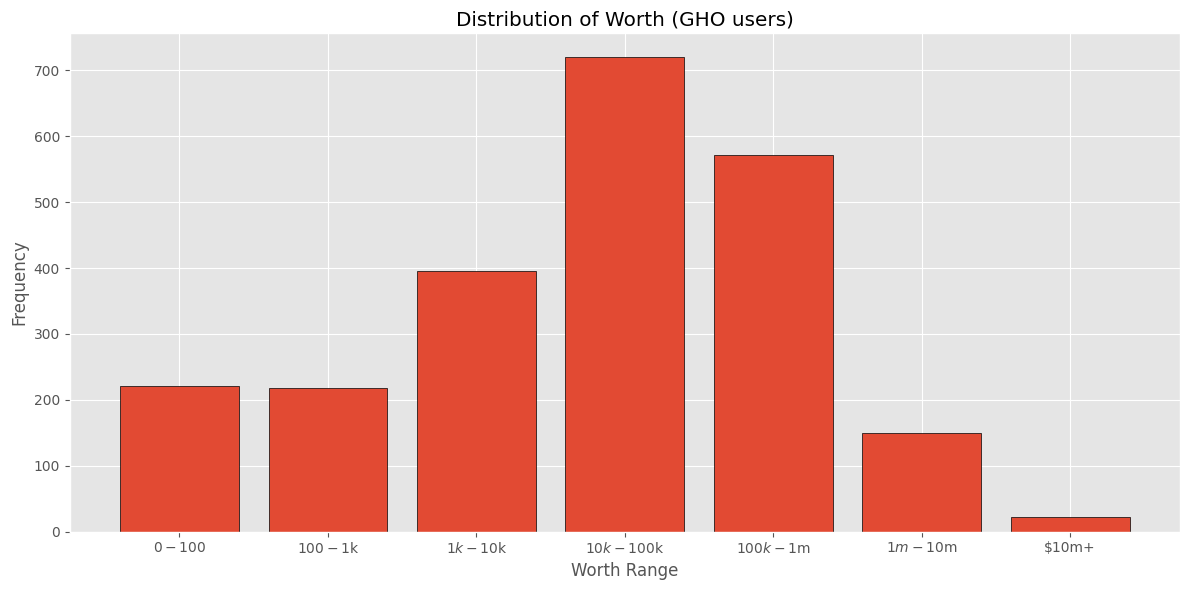

In [76]:
plt.figure(figsize=(12, 6))
counts, edges, _ = plt.hist(df_worth[df_worth['address'].isin(gho_users)]['worth'], bins=bins, edgecolor='black')

plt.clf()
plt.bar(range(len(counts)), counts, edgecolor='black')


plt.xticks(range(len(labels)), labels)


plt.xlabel('Worth Range')
plt.ylabel('Frequency')
plt.title('Distribution of Worth (GHO users)')

plt.tight_layout()
plt.show()

In [77]:
gho_dis = dict(zip(labels, counts))
gho_dis

{'$0-$100': 221.0,
 '$100-$1k': 218.0,
 '$1k-$10k': 396.0,
 '$10k-$100k': 720.0,
 '$100k-$1m': 571.0,
 '$1m-$10m': 149.0,
 '$10m+': 22.0}

In [78]:
{k: v / sum(gho_dis.values()) * 100 for k,v in gho_dis.items()}

{'$0-$100': 9.621245102307357,
 '$100-$1k': 9.490639965171964,
 '$1k-$10k': 17.23987810187201,
 '$10k-$100k': 31.34523291249456,
 '$100k-$1m': 24.858511101436655,
 '$1m-$10m': 6.486721811057902,
 '$10m+': 0.957771005659556}

/home/ben/.pyenv/versions/3.10.13/envs/boaenv/lib/python3.10/site-packages/matplotlib/axes/_axes.py:6895: RuntimeWarning: invalid value encountered in multiply
  boffset = -0.5 * dr * totwidth * (1 - 1 / nx)


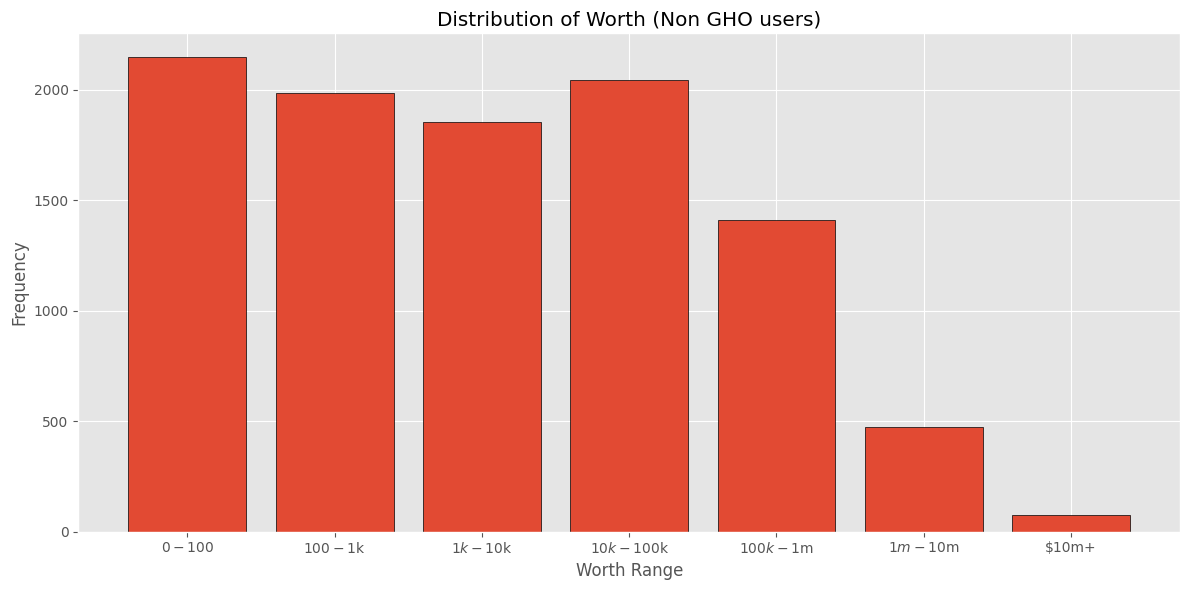

In [79]:
plt.figure(figsize=(12, 6))
counts, edges, _ = plt.hist(df_worth[~df_worth['address'].isin(gho_users)]['worth'], bins=bins, edgecolor='black')

plt.clf()
plt.bar(range(len(counts)), counts, edgecolor='black')


plt.xticks(range(len(labels)), labels)


plt.xlabel('Worth Range')
plt.ylabel('Frequency')
plt.title('Distribution of Worth (Non GHO users)')

plt.tight_layout()
plt.show()

In [80]:
gho_dis = dict(zip(labels, counts))
gho_dis

{'$0-$100': 2149.0,
 '$100-$1k': 1986.0,
 '$1k-$10k': 1855.0,
 '$10k-$100k': 2047.0,
 '$100k-$1m': 1413.0,
 '$1m-$10m': 473.0,
 '$10m+': 76.0}

In [81]:
{k: v / sum(gho_dis.values()) * 100 for k,v in gho_dis.items()}

{'$0-$100': 21.49214921492149,
 '$100-$1k': 19.861986198619864,
 '$1k-$10k': 18.55185518551855,
 '$10k-$100k': 20.47204720472047,
 '$100k-$1m': 14.13141314131413,
 '$1m-$10m': 4.730473047304731,
 '$10m+': 0.7600760076007601}

# Other protocols

In [44]:
import asyncio
import aiohttp
import time
import nest_asyncio
import pickle
from tqdm import tqdm

nest_asyncio.apply()

async def get_total_balance_async(address, session, timeout=30):
    url = f'https://pro-openapi.debank.com/v1/user/all_simple_protocol_list?id={address}'
    headers = {'accept': 'application/json', 'AccessKey': DEBANK_API_KEY}
    
    try:
        async with session.get(url, headers=headers, timeout=timeout) as response:
            if response.status == 200:
                result = await response.json()
                return address, result
            else:
                print(f"Error processing address {address}: HTTP {response.status}")
                return address, None
    except asyncio.TimeoutError:
        print(f"Timeout processing address {address}")
        return address, None
    except Exception as e:
        print(f"Error processing address {address}: {str(e)}")
        return address, None

async def process_addresses(addresses, batch_size=30, rate_limit=30, timeout=30):
    results = []
    pbar = tqdm(total=len(addresses), desc="Processing addresses")
    
    async with aiohttp.ClientSession() as session:
        for i in range(0, len(addresses), batch_size):
            batch = addresses[i:i+batch_size]
            start_time = time.time()
            
            tasks = [get_total_balance_async(address, session, timeout) for address in batch]
            batch_results = await asyncio.gather(*tasks)
            
            results.extend(batch_results)
            
            pbar.update(len(batch))
            
            with open('debank_protocol_intermediate.pickle', 'wb') as fp:
                pickle.dump(results, fp)
            
            elapsed_time = time.time() - start_time
            if elapsed_time < 1:
                await asyncio.sleep(1 - elapsed_time)
    
    pbar.close()
    return results

try:
    with open('debank_protocol_intermediate.pickle', 'rb') as fp:
        previous_results = pickle.load(fp)
    processed_addresses = set(result[0] for result in previous_results)
    remaining_addresses = [addr for addr in addresses if addr not in processed_addresses]
    print(f"Resuming from {len(previous_results)} previously processed addresses")
except FileNotFoundError:
    previous_results = []
    remaining_addresses = addresses

new_results = asyncio.get_event_loop().run_until_complete(process_addresses(remaining_addresses))
all_results = previous_results + new_results

with open('debank_protocol_final.pickle', 'wb') as fp:
    pickle.dump(all_results, fp)

print("Processing completed. Results saved in 'debank_protocol_final.pickle'")

Processing addresses: 100%|████████████████████████████████████████████████████| 12297/12297 [07:22<00:00, 27.79it/s]


Processing completed. Results saved in 'debank_protocol_final.pickle'


In [68]:
clean_res = [k for k in all_results if k[1] is not None and len(k[1]) > 0]
clean_res = [(k[0], [e for e in k[1] if 'Aave' not in e['name'] and e['asset_usd_value'] > 100]) for k in clean_res]
clean_res = [k for k in clean_res if k[1] is not None and len(k[1]) > 0]

protocols_df = pd.DataFrame({'address': _[0], 'protocols': list(set([name['name'] for name in _[1] if name['asset_usd_value'] > 100]))} for _ in clean_res)
protocols_df

,address,protocols
0,0xcdb1024a7c87f416ddf8f011f5813c685de441cd,[Koi]
1,0xbc722723a196133e6e70f778cc2e7f226b8f67e7,[De.Fi 2.0]
2,0x6978cc014f0dbf87fc9f791c7094573c33623c59,[LIDO]
3,0xb077ca14546ab8249fc0dc05cd1ff010445d0a3b,[Astherus]
4,0xf3861a66efb41c3a542f86bcd4cf7c1f44b4f01c,"[Merchant Moe, Camelot, Vertex, Beethoven x]"
...,...,...
5454,0xbb4499df08ef992d7194e09cbe210e9bc40750af,"[Beefy, Dolomite, Fluid, Avantis]"
5455,0xe3f0e88cfebfdb66d8591d9dbdcd14c6ebab485b,[Maker]
5456,0x8cc8aa103bfe1cd8755dc80c64539370b587909f,"[GMX, Llama Airforce Union, Stake DAO, ParaSwa..."
5457,0xf212ce21a97dbe30999a4c2b309d278bccbb686a,"[Curve, CoW Swap, Stargate, Goldfinch]"


In [66]:
def process_values(s, users, top: int = 25):
    res = s[:top] / users * 100
    return res.to_dict()

In [71]:
pd.Series([prot for prots in protocols_df['protocols'].to_list() for prot in prots if 'Aave' not in prot]).value_counts()

LIDO                    586
Pendle V2               513
Uniswap V3              513
ether.fi                471
EigenLayer              465
                       ... 
Defactor                  1
Polaris Finance           1
Ola Lending: ApeSwap      1
Amphora Protocol          1
Breeder                   1
Length: 1287, dtype: int64

In [70]:
process_values(pd.Series([prot for prots in protocols_df['protocols'].to_list() for prot in prots if 'Aave' not in prot]).value_counts(), len(addresses))

{'LIDO': 4.7653899325038624,
 'Pendle V2': 4.171749207123689,
 'Uniswap V3': 4.171749207123689,
 'ether.fi': 3.8302024884118073,
 'EigenLayer': 3.781410100024396,
 'Curve': 2.8543547206635766,
 'Stargate': 2.748637879157518,
 'ZeroLend': 2.6998454907701066,
 'Convex': 2.2688460600146376,
 'Compound V3': 2.2607139952834023,
 'Fuel': 2.2119216068959906,
 'Swell': 2.2037895421647558,
 'Ethena': 2.098072700658697,
 'Symbiotic': 2.0736765064649916,
 'Aerodrome': 2.0411482475400504,
 'GMX': 1.878506952915345,
 'Ambient': 1.87037488818411,
 'Karak': 1.8215824997966985,
 'Elixir': 1.7727901114092868,
 'Mendi Finance': 1.691469464096934,
 'SyncSwap': 1.618280881515817,
 'Beefy': 1.6020167520533461,
 'Velodrome V2': 1.4800357810848175,
 'Synthetix': 1.4475075221598763,
 'Mitosis': 1.4149792632349354}

## GHO USERS

In [154]:
df_gho_prot = protocols_df[protocols_df['address'].isin(gho_users)]

In [73]:
pd.Series([prot for prots in df_gho_prot['protocols'].to_list() for prot in prots if 'Aave' not in prot]).value_counts()

Pendle V2         177
Curve             165
ether.fi          157
EigenLayer        146
Uniswap V3        143
                 ... 
Alkemi Earn         1
Rollie Finance      1
Reaper Farm         1
Hana Finance        1
Breeder             1
Length: 857, dtype: int64

In [155]:
process_values(pd.Series([prot for prots in df_gho_prot['protocols'].to_list() for prot in prots if 'Aave' not in prot]).value_counts(), len(gho_users), 10)

{'Pendle V2': 7.705703090988246,
 'Curve': 7.18328254244667,
 'ether.fi': 6.835002176752286,
 'EigenLayer': 6.356116673922507,
 'Uniswap V3': 6.225511536787113,
 'Convex': 5.572485851110144,
 'LIDO': 5.398345668262952,
 'Aerodrome': 4.919460165433174,
 'GMX': 4.266434479756204,
 'Velodrome V2': 4.092294296909012}

## V3 USERS (NO GHO)

In [84]:
df_not_gho_prot = protocols_df[~protocols_df['address'].isin(gho_users)]

In [140]:
len(set(addresses) - set(gho_users))

10000

In [141]:
process_values(pd.Series([prot for prots in df_not_gho_prot['protocols'].to_list() for prot in prots if 'Aave' not in prot]).value_counts(), len(addresses), 10)

{'LIDO': 3.75701390583069,
 'Uniswap V3': 3.0088639505570463,
 'Pendle V2': 2.7323737496950473,
 'EigenLayer': 2.5941286492640483,
 'ether.fi': 2.553468325607872,
 'ZeroLend': 2.1631292185085793,
 'Stargate': 2.122468894852403,
 'Fuel': 1.837846629259169,
 'Compound V3': 1.6508091404407579,
 'Swell': 1.528828169472229}

## GHO NEW USERS

In [90]:
with open('gho_new_users.pkl', 'rb') as fp:
    gho_new_users = pickle.load(fp)

In [91]:
df_gho_new_users = protocols_df[protocols_df['address'].isin(gho_new_users)]

In [142]:
len(gho_new_users)

1128

In [157]:
pd.Series([prot for prots in df_gho_new_users['protocols'].to_list() for prot in prots if 'Aave' not in prot]).value_counts()

ether.fi           77
Pendle V2          75
EigenLayer         74
Uniswap V3         59
LIDO               58
                   ..
Robots Farm         1
Opium               1
Alpha Homora V2     1
Particle            1
GammaSwap           1
Length: 579, dtype: int64

In [158]:
process_values(pd.Series([prot for prots in df_gho_new_users['protocols'].to_list() for prot in prots if 'Aave' not in prot]).value_counts(), len(gho_new_users), 10)

{'ether.fi': 6.826241134751773,
 'Pendle V2': 6.648936170212766,
 'EigenLayer': 6.560283687943262,
 'Uniswap V3': 5.2304964539007095,
 'LIDO': 5.141843971631205,
 'Curve': 4.964539007092199,
 'Aerodrome': 4.609929078014184,
 'GMX': 3.8120567375886525,
 'Convex': 3.6347517730496453,
 'Beefy': 3.546099290780142}

## GHO OLD USERS

In [150]:
gho_old_users = set(gho_users) - set(gho_new_users)
gho_old_users = list(gho_old_users)

In [151]:
df_not_gho_new_users = protocols_df[protocols_df['address'].isin(gho_old_users)]

In [156]:
pd.Series([prot for prots in df_not_gho_new_users['protocols'].to_list() for prot in prots if 'Aave' not in prot]).value_counts()

Curve            109
Pendle V2        102
Convex            87
Uniswap V3        84
ether.fi          80
                ... 
COREx              1
Amply Finance      1
MetaStreet         1
BOB Bridge         1
Breeder            1
Length: 732, dtype: int64

In [152]:
process_values(pd.Series([prot for prots in df_not_gho_new_users['protocols'].to_list() for prot in prots if 'Aave' not in prot]).value_counts(), len(gho_old_users), 10)

{'Curve': 9.32420872540633,
 'Pendle V2': 8.72540633019675,
 'Convex': 7.442258340461934,
 'Uniswap V3': 7.18562874251497,
 'ether.fi': 6.8434559452523525,
 'EigenLayer': 6.159110350727117,
 'LIDO': 5.645851154833191,
 'Synthetix': 5.645851154833191,
 'Aerodrome': 5.218135158254919,
 'GMX': 4.704875962360992}

In [153]:
len(gho_old_users) + len(gho_new_users)

2297

## Some fine grained checking

### Pendle

In [107]:
gho_pendle_users = {}
for x in all_results:
    if x[0] not in gho_users:
        continue
    pendle_data = [a for a in x[1] if 'Pendle' in a['name'] and a['net_usd_value'] > 10]
    if not pendle_data:
        continue
    gho_pendle_users[x[0]] = pendle_data
len(gho_pendle_users)

207

In [110]:
gho_pendle_users

{'0xb1ee8ddfcfaa0b9e028e1d005e59c89957870c10': [{'id': 'pendle2',
   'chain': 'eth',
   'name': 'Pendle V2',
   'site_url': 'https://app.pendle.finance',
   'logo_url': 'https://static.debank.com/image/project/logo_url/pendle2/d5cfacd3b8f7e0ec161c0de9977cabbd.png',
   'has_supported_portfolio': True,
   'tvl': 2348831618.01542,
   'net_usd_value': 25460.45213784674,
   'asset_usd_value': 25460.45213784674,
   'debt_usd_value': 0}],
 '0xbb27900feda0d6c2d002f1249203c16d6de7a8e4': [{'id': 'arb_pendle2',
   'chain': 'arb',
   'name': 'Pendle V2',
   'site_url': 'https://app.pendle.finance',
   'logo_url': 'https://static.debank.com/image/project/logo_url/pendle2/d5cfacd3b8f7e0ec161c0de9977cabbd.png',
   'has_supported_portfolio': True,
   'tvl': 196917732.8720582,
   'net_usd_value': 2368.417218813393,
   'asset_usd_value': 2368.417218813393,
   'debt_usd_value': 0}],
 '0xcd9054a152b817c0098ff57c7a407a66736ef812': [{'id': 'arb_pendle2',
   'chain': 'arb',
   'name': 'Pendle V2',
   'site_u

In [109]:
nest_asyncio.apply()

async def get_pendle_details_async(address, session, timeout=30):
    url = f'https://pro-openapi.debank.com/v1/user/protocol?id={address}&protocol_id=pendle2'
    headers = {'accept': 'application/json', 'AccessKey': DEBANK_API_KEY}
    
    try:
        async with session.get(url, headers=headers, timeout=timeout) as response:
            if response.status == 200:
                result = await response.json()
                return address, result
            else:
                print(f"Error processing address {address}: HTTP {response.status}")
                return address, None
    except asyncio.TimeoutError:
        print(f"Timeout processing address {address}")
        return address, None
    except Exception as e:
        print(f"Error processing address {address}: {str(e)}")
        return address, None

async def process_addresses(addresses, batch_size=30, rate_limit=30, timeout=30):
    results = []
    pbar = tqdm(total=len(addresses), desc="Processing addresses")
    
    async with aiohttp.ClientSession() as session:
        for i in range(0, len(addresses), batch_size):
            batch = addresses[i:i+batch_size]
            start_time = time.time()
            
            tasks = [get_pendle_details_async(address, session, timeout) for address in batch]
            batch_results = await asyncio.gather(*tasks)
            
            results.extend(batch_results)
            
            pbar.update(len(batch))
            
            elapsed_time = time.time() - start_time
            if elapsed_time < 1:
                await asyncio.sleep(1 - elapsed_time)
    
    pbar.close()
    return results

pendle_data = asyncio.get_event_loop().run_until_complete(process_addresses(list(gho_pendle_users.keys())))

Processing addresses: 100%|████████████████████████████████████████████████████████| 207/207 [00:17<00:00, 12.16it/s]


In [111]:
nest_asyncio.apply()

async def get_pendle_details_async(address, session, timeout=30):
    url = f'https://pro-openapi.debank.com/v1/user/protocol?id={address}&protocol_id=arb_pendle2'
    headers = {'accept': 'application/json', 'AccessKey': DEBANK_API_KEY}
    
    try:
        async with session.get(url, headers=headers, timeout=timeout) as response:
            if response.status == 200:
                result = await response.json()
                return address, result
            else:
                print(f"Error processing address {address}: HTTP {response.status}")
                return address, None
    except asyncio.TimeoutError:
        print(f"Timeout processing address {address}")
        return address, None
    except Exception as e:
        print(f"Error processing address {address}: {str(e)}")
        return address, None

async def process_addresses(addresses, batch_size=30, rate_limit=30, timeout=30):
    results = []
    pbar = tqdm(total=len(addresses), desc="Processing addresses")
    
    async with aiohttp.ClientSession() as session:
        for i in range(0, len(addresses), batch_size):
            batch = addresses[i:i+batch_size]
            start_time = time.time()
            
            tasks = [get_pendle_details_async(address, session, timeout) for address in batch]
            batch_results = await asyncio.gather(*tasks)
            
            results.extend(batch_results)
            
            pbar.update(len(batch))
            
            elapsed_time = time.time() - start_time
            if elapsed_time < 1:
                await asyncio.sleep(1 - elapsed_time)
    
    pbar.close()
    return results

arb_pendle_data = asyncio.get_event_loop().run_until_complete(process_addresses(list(gho_pendle_users.keys())))

Processing addresses: 100%|████████████████████████████████████████████████████████| 207/207 [00:16<00:00, 12.76it/s]


In [129]:
assets = []

def extract_items(entry):
    if "portfolio_item_list" in entry:
        for stat in entry['portfolio_item_list']:
            if "asset_token_list" in stat:
                return [item['symbol'] for item in stat['asset_token_list']]
    return []
    
for i, arb_entry in enumerate(arb_pendle_data):
    user, data = pendle_data[i]
    _, arb_data = arb_entry
    assets += extract_items(data)
    assets += extract_items(arb_data)

In [134]:
pd.Series(assets).value_counts()[:15]

PENDLE                92
ETH                   57
USDe                  16
USDC                  14
PT-weETH-26SEP2024    10
PT-rsETH-26SEP2024     9
weETH                  9
ezETH                  8
WBTC                   8
WETH                   8
PT-ENA-29AUG2024       7
DAI                    7
PT-sUSDE-26SEP2024     7
YT-weETH-26SEP2024     7
rsETH                  7
dtype: int64

### Curve

In [160]:
gho_curve_users = {}
for x in all_results:
    if x[0] not in gho_users:
        continue
    pendle_data = [a for a in x[1] if 'Curve' in a['name'] and a['net_usd_value'] > 10]
    if not pendle_data:
        continue
    gho_curve_users[x[0]] = pendle_data
len(gho_curve_users)

250

In [162]:
gho_curve_users

{'0x0030b9f1925408d79be83c7cecfffdbacb638e9b': [{'id': 'curve',
   'chain': 'eth',
   'name': 'Curve',
   'site_url': 'https://curve.fi',
   'logo_url': 'https://static.debank.com/image/project/logo_url/curve/aa991be165e771cff87ae61e2a61ef68.png',
   'has_supported_portfolio': True,
   'tvl': 1996050493.9280145,
   'net_usd_value': 30.262623412308685,
   'asset_usd_value': 30.262623412308685,
   'debt_usd_value': 0}],
 '0x2b6c9f943b7cf5cd73b508d3525590fc7845b088': [{'id': 'curve',
   'chain': 'eth',
   'name': 'Curve',
   'site_url': 'https://curve.fi',
   'logo_url': 'https://static.debank.com/image/project/logo_url/curve/aa991be165e771cff87ae61e2a61ef68.png',
   'has_supported_portfolio': True,
   'tvl': 1996050493.9280145,
   'net_usd_value': 14.433001816791474,
   'asset_usd_value': 14.433001816791474,
   'debt_usd_value': 0}],
 '0xcfaba3994c45aa03e479000300801ae35b39c388': [{'id': 'curve',
   'chain': 'eth',
   'name': 'Curve',
   'site_url': 'https://curve.fi',
   'logo_url': 'ht

In [166]:
nest_asyncio.apply()

async def get_curve_details_async(address, session, timeout=30):
    url = f'https://pro-openapi.debank.com/v1/user/protocol?id={address}&protocol_id=curve'
    headers = {'accept': 'application/json', 'AccessKey': DEBANK_API_KEY}
    
    try:
        async with session.get(url, headers=headers, timeout=timeout) as response:
            if response.status == 200:
                result = await response.json()
                return address, result
            else:
                print(f"Error processing address {address}: HTTP {response.status}")
                return address, None
    except asyncio.TimeoutError:
        print(f"Timeout processing address {address}")
        return address, None
    except Exception as e:
        print(f"Error processing address {address}: {str(e)}")
        return address, None

async def process_addresses(addresses, batch_size=30, rate_limit=30, timeout=30):
    results = []
    pbar = tqdm(total=len(addresses), desc="Processing addresses")
    
    async with aiohttp.ClientSession() as session:
        for i in range(0, len(addresses), batch_size):
            batch = addresses[i:i+batch_size]
            start_time = time.time()
            
            tasks = [get_curve_details_async(address, session, timeout) for address in batch]
            batch_results = await asyncio.gather(*tasks)
            
            results.extend(batch_results)
            
            pbar.update(len(batch))
            
            elapsed_time = time.time() - start_time
            if elapsed_time < 1:
                await asyncio.sleep(1 - elapsed_time)
    
    pbar.close()
    return results

curve_data = asyncio.get_event_loop().run_until_complete(process_addresses(list(gho_curve_users.keys())))

Processing addresses: 100%|████████████████████████████████████████████████████████| 250/250 [00:17<00:00, 14.39it/s]


In [172]:
assets = []
    
for i, entry in enumerate(curve_data):
    _, data = entry
    assets += extract_items(data)

In [173]:
pd.Series(assets).value_counts()[:15]

CRV       142
USDC      127
DAI       122
USDT      121
ETH        24
stETH      16
USD0       14
FRAX        9
GHO         9
crvUSD      6
cvxCRV      5
LDO         5
sUSD        5
GEAR        3
sdCRV       3
dtype: int64